# Comparing Sudoku solver algorithms


In [1]:
import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.manifold import TSNE
import altair as alt
from altair import datum
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
import tensorflow as tf
alt.data_transformers.disable_max_rows()

/Users/karinprem/miniconda3/envs/XAI/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DataTransformerRegistry.enable('default')

In [2]:
try: 
  from google.colab import drive
  drive.mount('/content/drive')
  DF_PATH = '/content/drive/MyDrive/sudoku_dataset.csv' 
  DF_TRAIN_PATH = '/content/drive/MyDrive/sudoku_js.csv' 
except: 
  DF_PATH = './data/sudoku/sudoku_dataset.csv'
  DF_TRAIN_PATH = './data/sudoku/sudoku_js.csv'

## Rules of Sudoku

Sudoku is a single player game. One needs to fill out the empty spaces with integer numbers between 1 and 9.

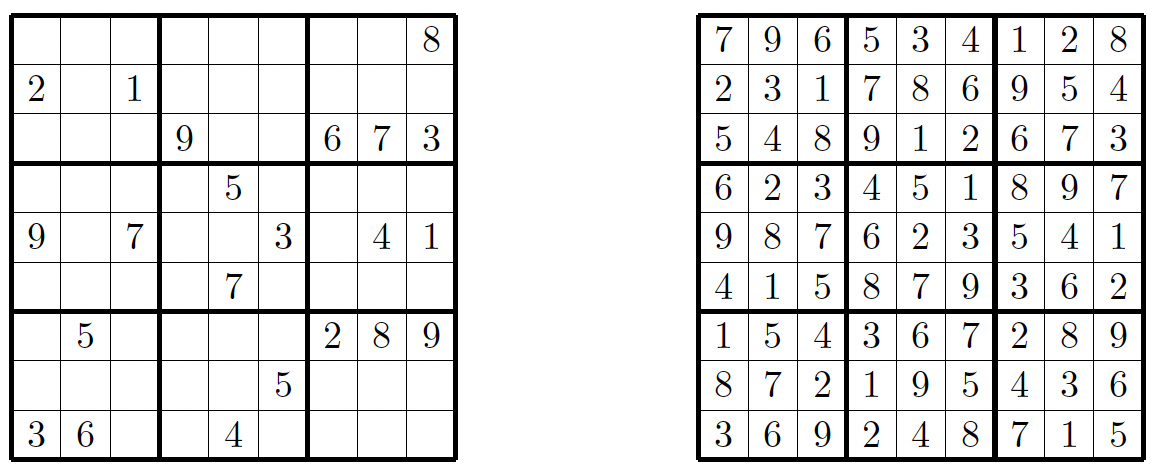

For a valid solution, in every row must be all numbers between 1 and 9. In every column must be all numbers between 1 and 9 and in each of the 9 boxes must be all numbers between 1 and 9.

(image source: https://www.kth.se/social/files/58861771f276547fe1dbf8d1/HLaestanderMHarrysson_dkand14.pdf)

## Sudoku solver algorithms

---



The following two algorithms were compared:


*   **Brute force algorithm**: Loop over all empty cells and, determine what numbers are vaild, and try them all in a depth-first search.
*   **Knuth AlgorithmX**: Also uses depth-first search but uses heuristics. The algorithm was created for a more generic problem. Computation is performed on a transformed space and therefore not easy to follow. Details on how Knuth AlgorithmX can be found in this about 30-pages document: https://www.kth.se/social/files/58861771f276547fe1dbf8d1/HLaestanderMHarrysson_dkand14.pdf




## Data structures

**Boad state**: List of 81 numbers, 0 if field is empty, row by row.

**Solution path**: List board states from inital state to solution.



## Data generation

We created Python code that can create valid initial states and the solution steps for both algorithms.

This was based on the following two sources: 

* https://github.com/TarikGul/Sudoku-solving-visualizer
* https://www.cs.mcgill.ca/~aassaf9/python/sudoku.txt



## Dataset

The dataset is a csv file that contains ten games played by both algorithms. The file size is approximately 0.5 MB.

In [3]:
df = pd.read_csv(DF_PATH)
print(df.shape)
df.head()

(2968, 85)


# game  init  algorithm  step  r1c1  r1c2  r1c3  r1c4  r1c5  r1c6  ...  \
0       1     1          1     1     0     5     0     4     9     0  ...   
1       1     1          1     2     2     5     0     4     9     0  ...   
2       1     1          1     3     2     5     3     4     9     0  ...   
3       1     1          1     4     2     5     3     4     9     6  ...   
4       1     1          1     5     2     5     3     4     9     6  ...   

   r8c9  r9c1  r9c2  r9c3  r9c4  r9c5  r9c6  r9c7  r9c8  r9c9  
0     2     9     0     0     0     2     7     0     0     0  
1     2     9     0     0     0     2     7     0     0     0  
2     2     9     0     0     0     2     7     0     0     0  
3     2     9     0     0     0     2     7     0     0     0  
4     2     9     0     0     0     2     7     0     0     0  

[5 rows x 85 columns]

## Projections

We used 4 projection methods and created about 150 diagrams.

In the diagrams the red point is the initial state of the game and the green point is the end of the game.

### tSNE Method

In [4]:
def plot_py_ds(df, game, perplexity):
    df = df[df['init'] == game].copy()
    alg_1 = df[df['algorithm'] == 1]
    alg_2 = df[df['algorithm'] == 2]
    alg_1_embedded = TSNE(n_components = 2, learning_rate = 'auto', init = 'random', perplexity = perplexity, random_state = 32).fit_transform(alg_1.iloc[:, -81:])
    alg_2_embedded = TSNE(n_components = 2, learning_rate = 'auto', init = 'random', perplexity = perplexity, random_state = 32).fit_transform(alg_2.iloc[:, -81:])

    alg_1_2 = pd.concat([alg_1, alg_2], axis=0)
    alg_1_2_embedded = TSNE(n_components = 2, learning_rate = 'auto', init = 'random', perplexity = perplexity, random_state = 32).fit_transform(alg_1_2.iloc[:, -81:])
    alg_1_embedded = alg_1_2_embedded[0:alg_1_embedded.shape[0],:]
    alg_2_embedded = alg_1_2_embedded[alg_1_embedded.shape[0]:,:]

    df_alg_1_embedded = pd.DataFrame(alg_1_embedded, columns = ['x', 'y'])
    df_alg_1_embedded.reset_index(inplace=True) # adding index column
    df_alg_1_embedded['type'] = 'brute force algorithm' # adding type for addding it to a legend
    df_alg_2_embedded = pd.DataFrame(alg_2_embedded, columns = ['x', 'y']) 
    df_alg_2_embedded.reset_index(inplace=True) 
    df_alg_2_embedded['type'] = 'knuth algorithm'
    
    a1 = alt.Chart(df_alg_1_embedded).mark_line(point = alt.OverlayMarkDef(size = 30), strokeWidth = 0.15, tooltip = True).encode(
        x='x',
        y='y',
        color = alt.Color('type', legend = alt.Legend(title="Type of the Algorithm")),
        order='index:Q',
        tooltip=["type", "x", "y"]
    ).properties(
        width=500,
        height=400,
        title=f'tSNE Method (game = {game}, perplexity = {perplexity})'
    ).interactive()

    a2 = alt.Chart(df_alg_2_embedded).mark_line(point = alt.OverlayMarkDef(size = 50), strokeWidth = 0.6, tooltip = True).encode(
        x='x',
        y='y',
        color = alt.Color('type'),
        order='index:Q',
        tooltip=["type", "x", "y"]
    ).properties(
        width=500,
        height=400
    ).interactive()

    startpoint1 = alt.Chart(df_alg_1_embedded.iloc[0:1]).mark_point(color='red', filled=True, size=300).encode(x='x',y='y')
    startpoint2 = alt.Chart(df_alg_2_embedded.iloc[0:1]).mark_point(color='red', filled=True, size=300).encode(x='x',y='y')
    endpoint1 = alt.Chart(df_alg_2_embedded.iloc[-1:]).mark_point(color='green', filled=True, size=300).encode(x='x',y='y')
    endpoint2 = alt.Chart(df_alg_2_embedded.iloc[-1:]).mark_point(color='green', filled=True, size=300).encode(x='x',y='y')
    chart = a1+a2+startpoint1+endpoint1+startpoint2+endpoint2
    chart.display()
    
for game in range(1, 11):
  for perplexity in (5, 15, 30):
    plot_py_ds(df.iloc[:, 1:], game, perplexity)


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

### PCA Method

In [5]:
def plot_py_ds(df, game, svd_solver):
    df = df[df['init'] == game] 
    alg_1 = df[df['algorithm'] == 1]
    alg_2 = df[df['algorithm'] == 2]
    alg_1_embedded = PCA(n_components = 2, svd_solver = svd_solver, random_state = 32).fit_transform(alg_1.iloc[:, -81:])
    alg_2_embedded = PCA(n_components = 2, svd_solver = svd_solver, random_state = 32).fit_transform(alg_2.iloc[:, -81:])
    
    alg_1_2 = pd.concat([alg_1, alg_2], axis=0)
    alg_1_2_embedded = PCA(n_components = 2, svd_solver = svd_solver, random_state = 32).fit_transform(alg_1_2.iloc[:, -81:])
    alg_1_embedded = alg_1_2_embedded[0:alg_1_embedded.shape[0],:]
    alg_2_embedded = alg_1_2_embedded[alg_1_embedded.shape[0]:,:]

    df_alg_1_embedded = pd.DataFrame(alg_1_embedded, columns = ['x', 'y'])
    df_alg_1_embedded.reset_index(inplace=True) # adding index column
    df_alg_1_embedded['type'] = 'brute force algorithm' # adding type for addding it to a legend
    df_alg_2_embedded = pd.DataFrame(alg_2_embedded, columns = ['x', 'y']) 
    df_alg_2_embedded.reset_index(inplace=True) 
    df_alg_2_embedded['type'] = 'knuth algorithm'
    
    a1 = alt.Chart(df_alg_1_embedded).mark_line(point = alt.OverlayMarkDef(size = 30), strokeWidth = 0.15, tooltip = True).encode(
        x='x',
        y='y',
        color = alt.Color('type', legend=alt.Legend(title="Type of the Algorithm")),
        order='index:Q',
        tooltip=["type", "x", "y"]
    ).properties(
        width=500,
        height=400,
        title=f'PCA Method (game = {game}, svd_solver = {svd_solver})'
    ).interactive()

    a2 = alt.Chart(df_alg_2_embedded).mark_line(point = alt.OverlayMarkDef(size = 50), strokeWidth = 0.6, tooltip = True).encode(
        x='x',
        y='y',
        color = alt.Color('type'),
        order='index:Q',
        tooltip=["type", "x", "y"]
    ).properties(
        width=500,
        height=400
    ).interactive()

    startpoint1 = alt.Chart(df_alg_1_embedded.iloc[0:1]).mark_point(color='red', filled=True, size=300).encode(x='x',y='y')
    startpoint2 = alt.Chart(df_alg_2_embedded.iloc[0:1]).mark_point(color='red', filled=True, size=300).encode(x='x',y='y')
    endpoint1 = alt.Chart(df_alg_1_embedded.iloc[-1:]).mark_point(color='green', filled=True, size=300).encode(x='x',y='y')
    endpoint2 = alt.Chart(df_alg_2_embedded.iloc[-1:]).mark_point(color='green', filled=True, size=300).encode(x='x',y='y')
    chart = a1+a2+startpoint1+endpoint1+startpoint2+endpoint2
    chart.display()
    
for game in range(1, 11):
  for svd_solver in ['auto', 'full', 'arpack', 'randomized']:
    plot_py_ds(df.iloc[:, 1:], game, svd_solver)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

### ICA Method

In [6]:
def plot_py_ds(df, game, algorithm, function):
    df = df[df['init'] == game] 
    alg_1 = df[df['algorithm'] == 1]
    alg_2 = df[df['algorithm'] == 2]
    alg_1_embedded = FastICA(n_components = 2, algorithm = algorithm, fun = function, random_state = 32).fit_transform(alg_1.iloc[:, -81:])
    alg_2_embedded = FastICA(n_components = 2, algorithm = algorithm, fun = function, random_state = 32).fit_transform(alg_2.iloc[:, -81:])
    
    alg_1_2 = pd.concat([alg_1, alg_2], axis=0)
    alg_1_2_embedded = FastICA(n_components = 2, algorithm = algorithm, fun = function, random_state = 32).fit_transform(alg_1_2.iloc[:, -81:])
    alg_1_embedded = alg_1_2_embedded[0:alg_1_embedded.shape[0],:]
    alg_2_embedded = alg_1_2_embedded[alg_1_embedded.shape[0]:,:]
    
    df_alg_1_embedded = pd.DataFrame(alg_1_embedded, columns = ['x', 'y'])
    df_alg_1_embedded.reset_index(inplace=True) # adding index column
    df_alg_1_embedded['type'] = 'brute force algorithm' # adding type for addding it to a legend
    df_alg_2_embedded = pd.DataFrame(alg_2_embedded, columns = ['x', 'y']) 
    df_alg_2_embedded.reset_index(inplace=True) 
    df_alg_2_embedded['type'] = 'knuth algorithm'
    
    a1 = alt.Chart(df_alg_1_embedded).mark_line(point = alt.OverlayMarkDef(size = 30), strokeWidth = 0.15, tooltip = True).encode(
        x='x',
        y='y',
        color = alt.Color('type', legend=alt.Legend(title="Type of the Algorithm")),
        order='index:Q',
        tooltip=["type", "x", "y"]
    ).properties(
        width=500,
        height=400,
        title=f'FastICA Method (game = {game}, algorithm = {algorithm}, function = {function})'
    ).interactive()

    a2 = alt.Chart(df_alg_2_embedded).mark_line(point = alt.OverlayMarkDef(size = 50), strokeWidth = 0.6, tooltip = True).encode(
        x='x',
        y='y',
        color = alt.Color('type'),
        order='index:Q',
        tooltip=["type", "x", "y"]
    ).properties(
        width=500,
        height=400
    ).interactive()

    startpoint1 = alt.Chart(df_alg_1_embedded.iloc[0:1]).mark_point(color='red', filled=True, size=300).encode(x='x',y='y')
    startpoint2 = alt.Chart(df_alg_2_embedded.iloc[0:1]).mark_point(color='red', filled=True, size=300).encode(x='x',y='y')
    endpoint1 = alt.Chart(df_alg_1_embedded.iloc[-1:]).mark_point(color='green', filled=True, size=300).encode(x='x',y='y')
    endpoint2 = alt.Chart(df_alg_2_embedded.iloc[-1:]).mark_point(color='green', filled=True, size=300).encode(x='x',y='y')
    chart = a1+a2+startpoint1+endpoint1+startpoint2+endpoint2
    chart.display()
    
for game in range(1, 11):
  for algorithm in ['parallel', 'deflation']:
    for function in ['logcosh', 'exp', 'cube']:
      plot_py_ds(df.iloc[:, 1:], game, algorithm, function)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

/Users/karinprem/miniconda3/envs/XAI/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

/Users/karinprem/miniconda3/envs/XAI/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

### Autoencoder

In [7]:
def train_ae(n_hidden = 32, batch_size = 4096, n_epochs = 5000, learning_rate = 1e-2):

  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)


  class Encoder(tf.keras.Model):
      def __init__(self, n_hidden, n_encoded):
          super().__init__()
          
          self.dense1 = tf.keras.layers.Dense(n_hidden)
          self.dense2 = tf.keras.layers.Dense(n_encoded)
      
      def call(self, inputs, training = True):
          x = self.dense1(inputs) 
          x = tf.keras.activations.relu(x)
          x = self.dense2(x)
          return x

  class Decoder(tf.keras.Model):
      def __init__(self, n_hidden, n_decoded):
          super().__init__()
          
          self.dense1 = tf.keras.layers.Dense(n_hidden)
          self.dense2 = tf.keras.layers.Dense(n_decoded)
      
      def call(self, inputs, training = True):
          x = self.dense1(inputs) 
          x = tf.keras.activations.relu(x)
          x = self.dense2(x)
          return x
      
  class Autoencoder(tf.keras.Model):
      def __init__(self, n_features, n_hidden, n_encoded):
          super().__init__()
          self.n_hidden = n_hidden
          self.n_encoded = n_encoded
          self.n_features = n_features
      
      def build(self, inputs): 
          self.encoder = Encoder(self.n_hidden, self.n_encoded)
          self.decoder = Decoder(self.n_hidden, self.n_features)
      
      def call(self, inputs):
          encoded = self.encoder(inputs)
          decoded = self.decoder(encoded)
          return decoded

      def encode(self, X):
          return self.encoder(X).numpy()

  train_ = pd.read_csv(DF_TRAIN_PATH).iloc[:, 0:81].to_numpy()

  ae = Autoencoder(81, n_hidden, 2)
  ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = 'mean_squared_error')

  ae.fit(train_, train_, epochs = n_epochs, batch_size = batch_size, verbose = False)

  return ae

In [8]:
def plot_py_ds_ae(game, df, ae, metadata: dict):
    df = df[df['init'] == game] 
    alg_1 = df[df['algorithm'] == 1].iloc[:, -81:].to_numpy()
    alg_2 = df[df['algorithm'] == 2].iloc[:, -81:].to_numpy()

    alg_1_embedded = ae.encode(alg_1)
    alg_2_embedded = ae.encode(alg_2)

    df_alg_1_embedded = pd.DataFrame(alg_1_embedded, columns = ['x', 'y'])
    df_alg_1_embedded.reset_index(inplace=True) # adding index column
    df_alg_1_embedded['type'] = 'brute force algorithm' # adding type for addding it to a legend
    df_alg_2_embedded = pd.DataFrame(alg_2_embedded, columns = ['x', 'y']) 
    df_alg_2_embedded.reset_index(inplace=True) 
    df_alg_2_embedded['type'] = 'knuth algorithm'
    
    a1 = alt.Chart(df_alg_1_embedded).mark_line(point = alt.OverlayMarkDef(size = 30), strokeWidth = 0.15, tooltip = True).encode(
        x='x',
        y='y',
        color = alt.Color('type', legend=alt.Legend(title="Type of the Algorithm")),
        order='index:Q',
        tooltip=["type", "x", "y"]
    ).properties(
        width=500,
        height=400,
        title=f'Autoencoder Method (game = {game}, {metadata})'
    ).interactive()

    a2 = alt.Chart(df_alg_2_embedded).mark_line(point = alt.OverlayMarkDef(size = 50), strokeWidth = 0.6, tooltip = True).encode(
        x='x',
        y='y',
        color = alt.Color('type'),
        order='index:Q',
        tooltip=["type", "x", "y"]
    ).properties(
        width=500,
        height=400
    ).interactive()

    startpoint1 = alt.Chart(df_alg_1_embedded.iloc[0:1]).mark_point(color='red', filled=True, size=300).encode(x='x',y='y')
    startpoint2 = alt.Chart(df_alg_2_embedded.iloc[0:1]).mark_point(color='red', filled=True, size=300).encode(x='x',y='y')
    endpoint1 = alt.Chart(df_alg_1_embedded.iloc[-1:]).mark_point(color='green', filled=True, size=300).encode(x='x',y='y')
    endpoint2 = alt.Chart(df_alg_2_embedded.iloc[-1:]).mark_point(color='green', filled=True, size=300).encode(x='x',y='y')
    chart = a1+a2+startpoint1+endpoint1+startpoint2+endpoint2
    chart.display()


grid = [
    {
        'learning_rate': 2e-2,
        'n_epochs': 5000, 
        'batch_size': 4096,
        'n_hidden': 32
    },
    {
        'learning_rate': 2e-2,
        'n_epochs': 5000, 
        'batch_size': 4096,
        'n_hidden': 16
    }
]

for g in grid: 
    ae = train_ae(**g)
    for game in range(1, 11):
        plot_py_ds_ae(game, df, ae, metadata = g)

2022-11-09 16:13:45.451810: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 16:13:45.599687: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

## Results and interpetations

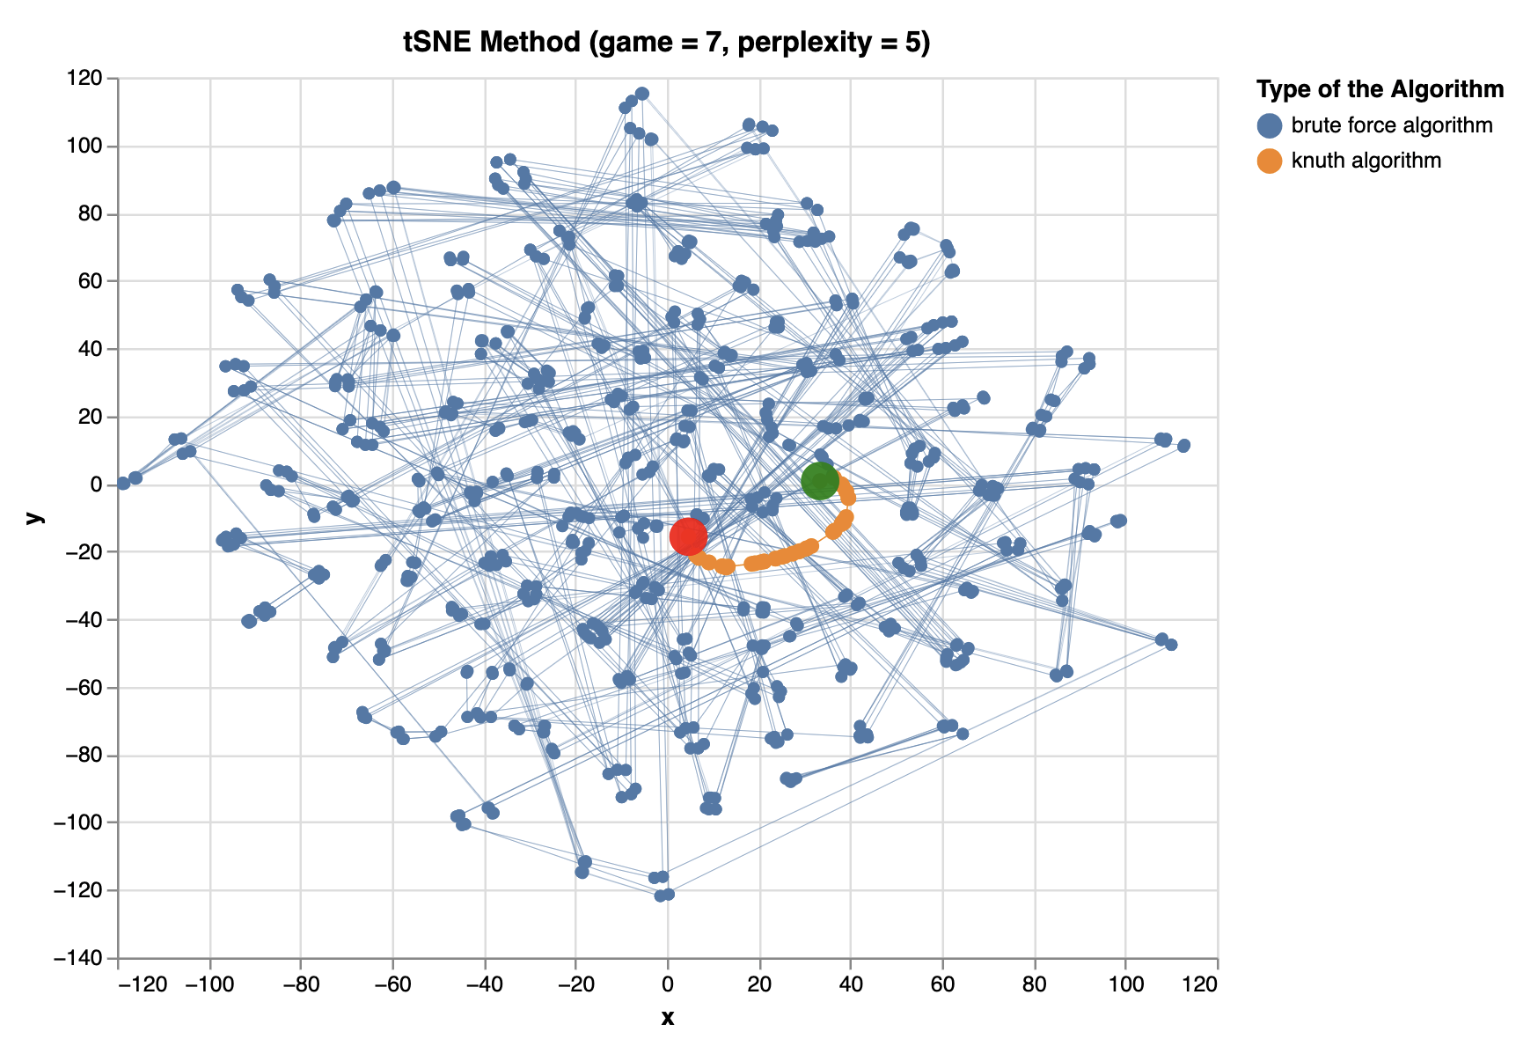

Knuth algorithm finds its path more efficiently.

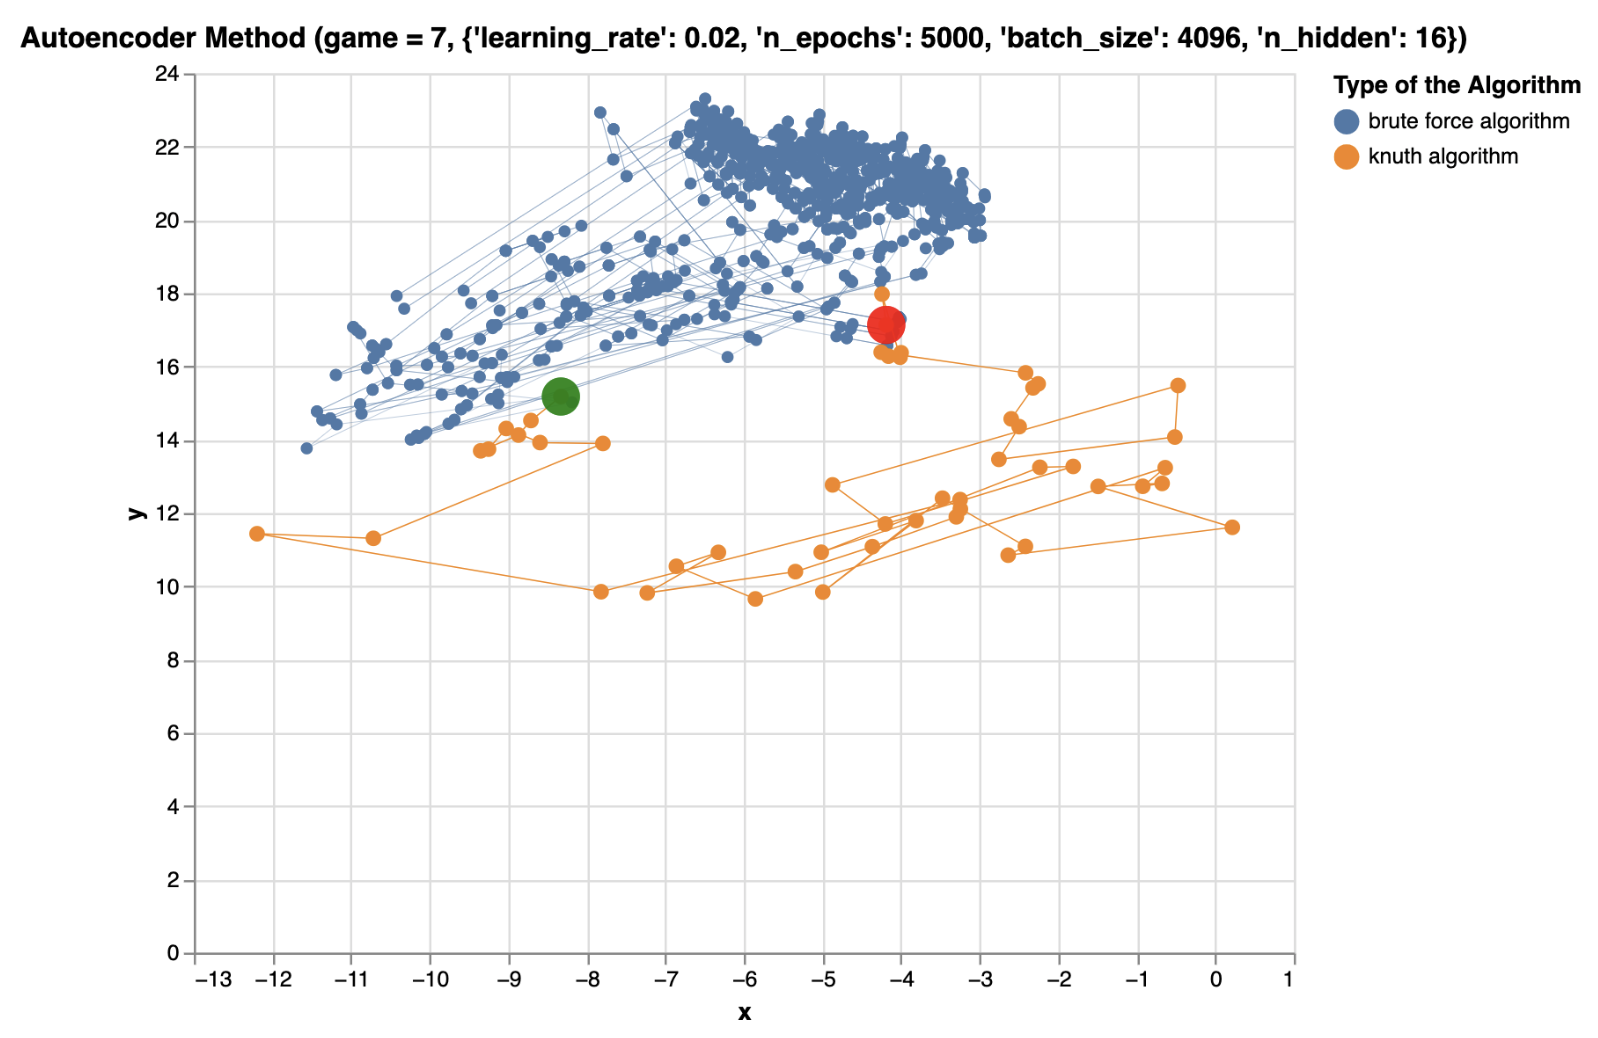

In the projection for the same game it can be seen that the paths of the two algorithms split very early.

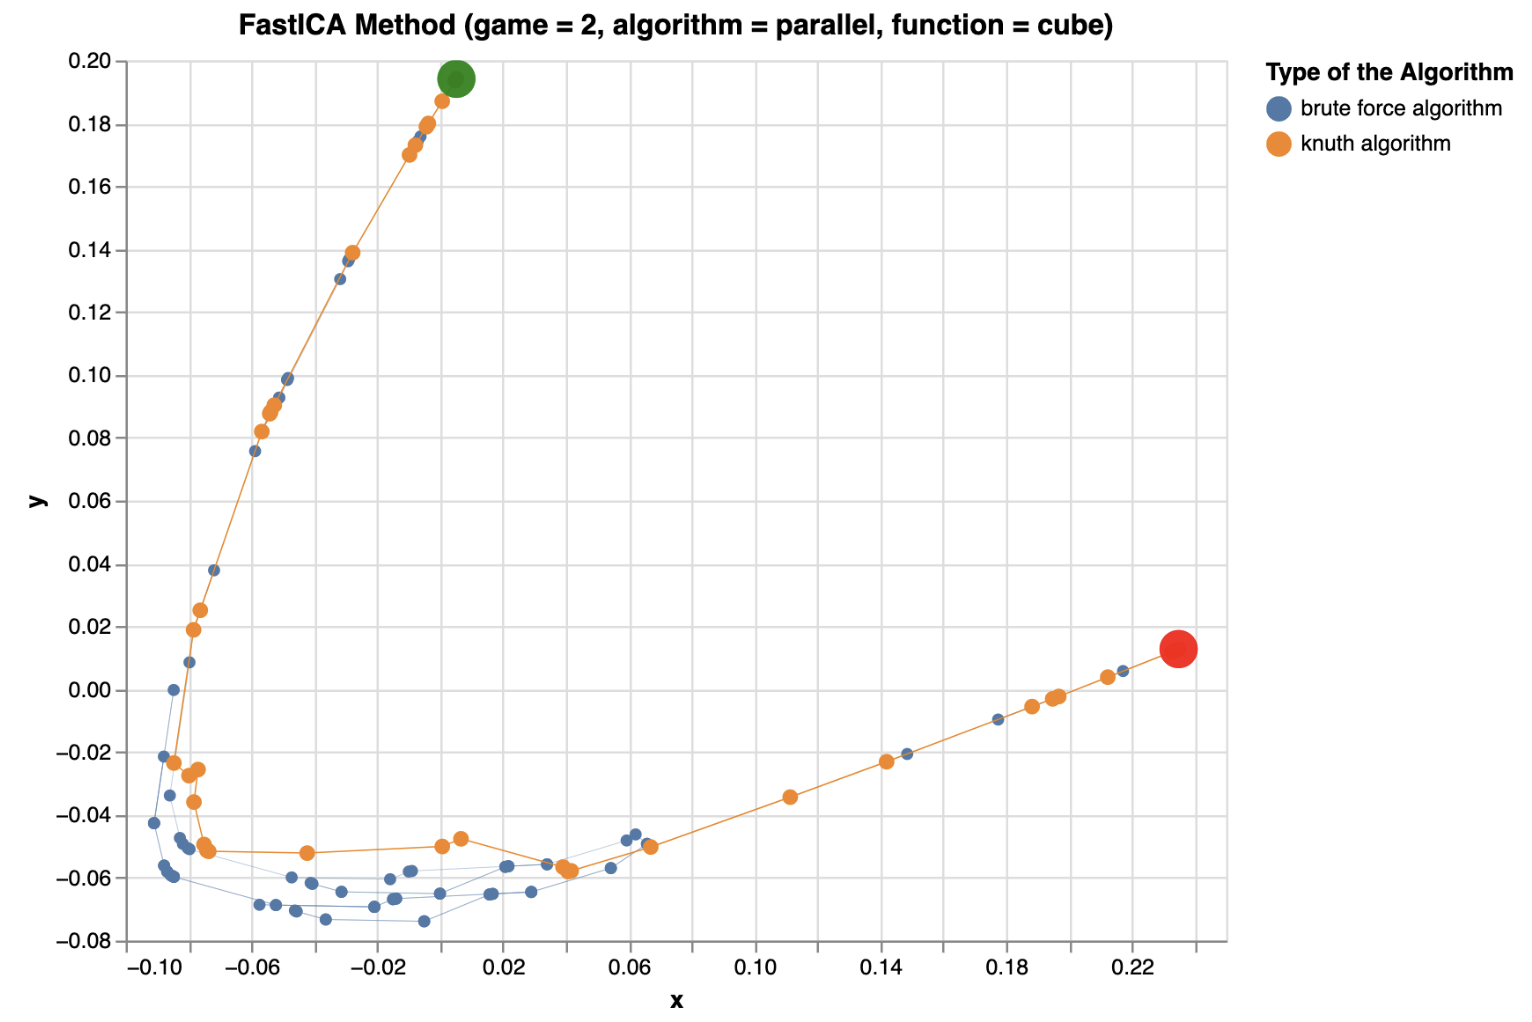

Sometimes the algorithms behave similarly at the beginning and at the end, but Knuth's algorithm finds some shortcut in the middle.

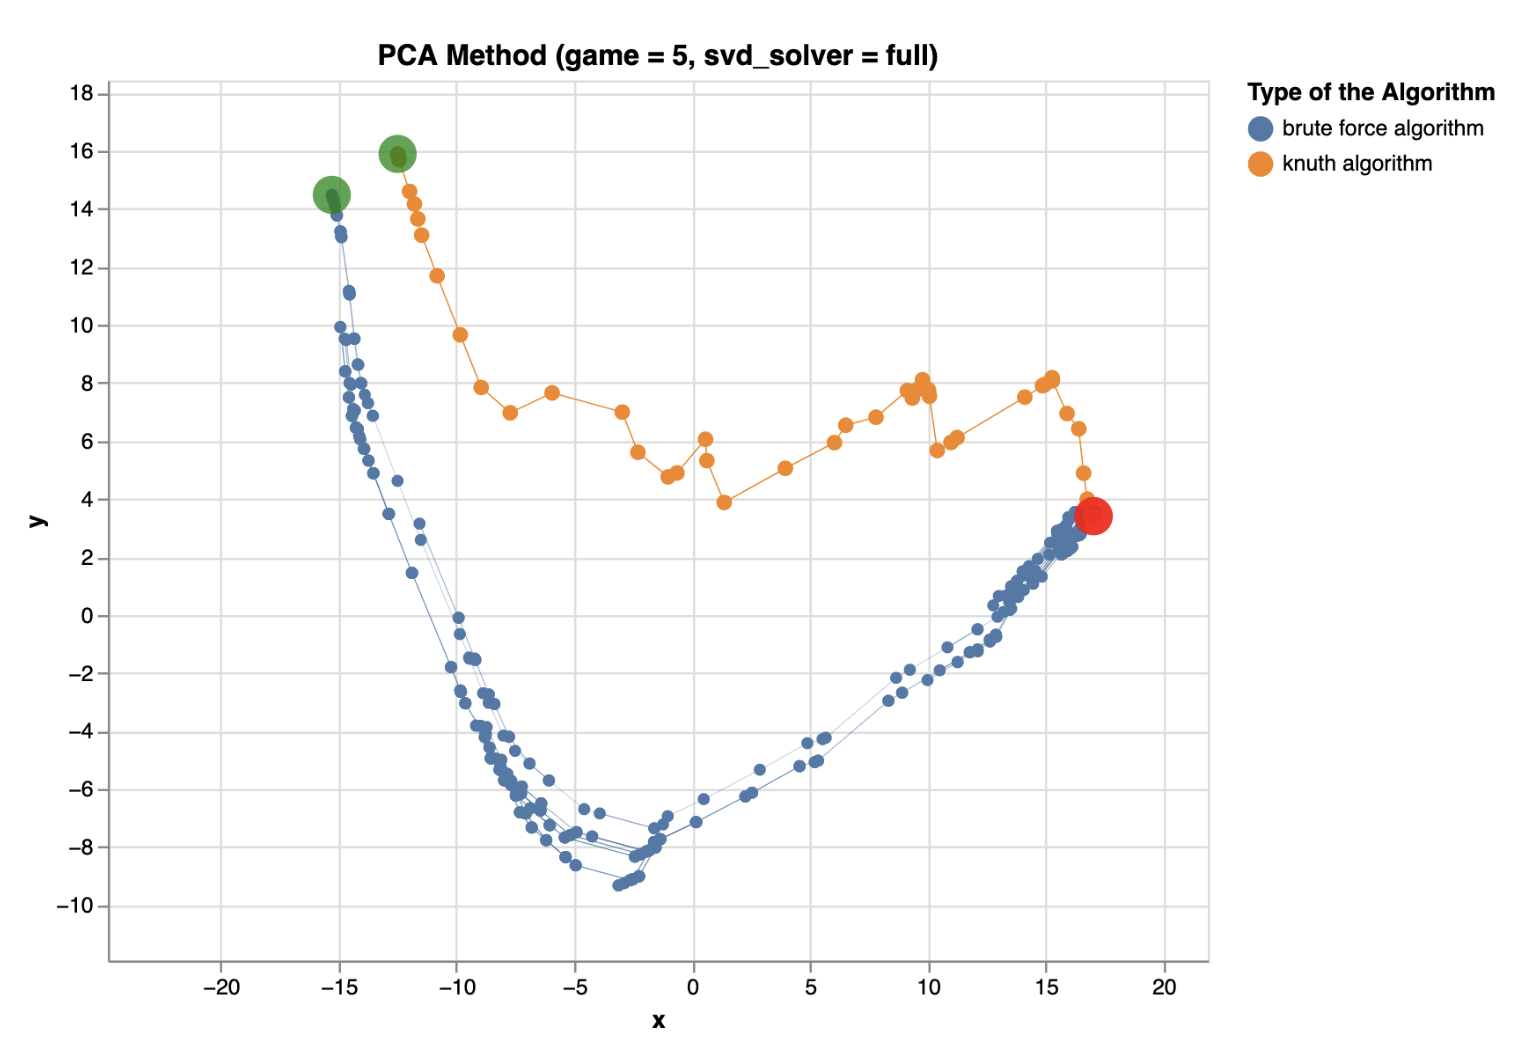

For some initial states there is more than one correct solution.

There were two effects that surprised. Both effects are visible in many different diagrams:

* Knuth's algorithm often takes different steps from the brute force algorithm already at the beginning of the game. This is different from the projections of the Rubik's cube algorithm.
+ There is hardly any backtracking visible for Knuth's algorithm. This is surprising because Knuth's algorithm is a depth-first search algorithm that operates on heuristics. So, it seems the heuristics of Knuth's algorithm are of high quality.